# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# Vanilla RNN Implementation

In [3]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.rnn = nn.RNN(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:
def clean_word(word):
    import string
    clean_word = word.translate(str.maketrans('', '', string.punctuation))
    clean_word = clean_word.strip()
    if not clean_word:
        return ' ' * len(word)
    else:
        return clean_word
    
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
rnn_word2vec_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_word2vec_model.parameters(), lr=0.001)

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4435, Accuracy: 0.8905, F1: 0.3496
Validation: Loss: 0.3439, Accuracy: 0.9122, F1: 0.4549
Epoch 2/10
Training: Loss: 0.3314, Accuracy: 0.9128, F1: 0.4730
Validation: Loss: 0.3170, Accuracy: 0.9171, F1: 0.4937
Epoch 3/10
Training: Loss: 0.2999, Accuracy: 0.9195, F1: 0.5179
Validation: Loss: 0.2980, Accuracy: 0.9189, F1: 0.5207
Epoch 4/10
Training: Loss: 0.2815, Accuracy: 0.9242, F1: 0.5491
Validation: Loss: 0.2957, Accuracy: 0.9202, F1: 0.5270
Epoch 5/10
Training: Loss: 0.2705, Accuracy: 0.9259, F1: 0.5630
Validation: Loss: 0.2989, Accuracy: 0.9219, F1: 0.5322
Epoch 6/10
Training: Loss: 0.2600, Accuracy: 0.9285, F1: 0.5826
Validation: Loss: 0.2989, Accuracy: 0.9198, F1: 0.5370
Epoch 7/10
Training: Loss: 0.2577, Accuracy: 0.9289, F1: 0.5851
Validation: Loss: 0.2843, Accuracy: 0.9260, F1: 0.5473
Epoch 8/10
Training: Loss: 0.2507, Accuracy: 0.9310, F1: 0.6025
Validation: Loss: 0.2813, Accuracy: 0.9271, F1: 0.5548
Epoch 9/10
Training: Loss: 0.2462, Accuracy: 0.9

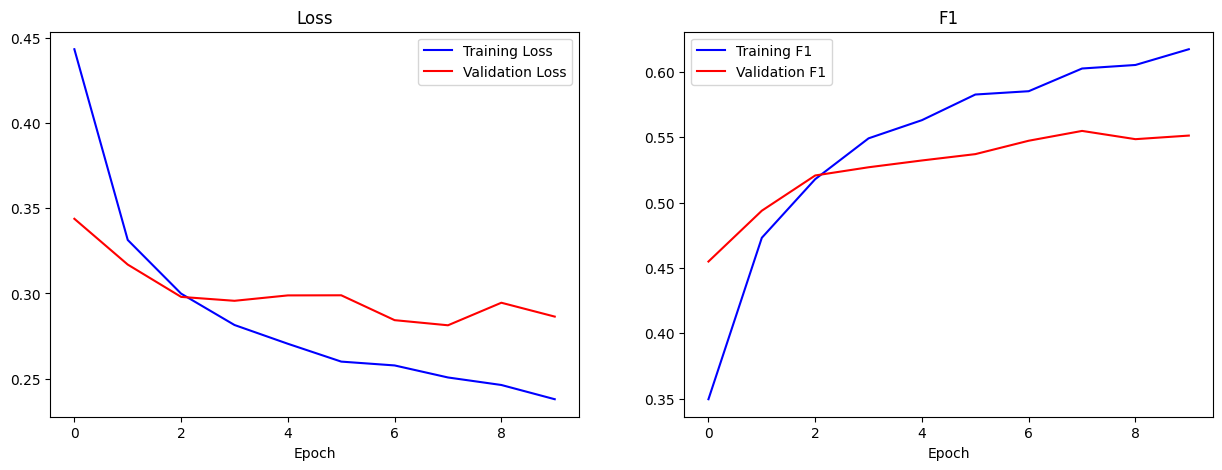

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
# fine_tune(rnn_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [13]:
rnn_word2vec_model = rnn_word2vec_model.to('cpu')
torch.save(rnn_word2vec_model, "t1_model1_word2vec.pt")

In [14]:
test_accuracy, test_f1 = test("t1_model1_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.04295346107467781, 1: 0.05725971370143149, 2: 0.15731922398589065, 3: 0.031462585034013606, 4: 0.03070175438596491, 5: 0.07824726134585289, 6: 0.06643835616438357, 7: 0.13003663003663005, 8: 0.08962536023054754, 9: 0.3060796645702306, 10: 0.18552147239263803, 11: 0.09295570079883805, 12: 0.10073260073260072, 13: 0.045774647887323945, 14: 0.04251700680272109, 15: 0.05994673222700266, 16: 0.3003300330033003, 17: 0.15384615384615383, 18: 0.07142857142857142, 19: 0.06530612244897958, 20: 0.05263157894736842, 21: 0.0, 22: 0.0, 23: 0.1543859649122807, 24: 0.2222222222222222, 25: 0.27777777777777773, 26: 0.0632183908045977}
Labelwise Accuracy Scores:
{0: 0.9761471230881282, 1: 0.34710743801652894, 2: 0.6482558139534884, 3: 0.23270440251572327, 4: 0.22580645161290322, 5: 0.5434782608695652, 6: 0.49743589743589745, 7: 0.6396396396396397, 8: 0.8120104438642297, 9: 0.8488372093023255, 10: 0.8649885583524027, 11: 0.7191011235955056, 12: 0.6748466257668712, 13: 0.22413793

# For GloVe Embeddings

In [15]:
rnn_glove_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(rnn_glove_model.parameters(), lr=0.1)

In [16]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.6055, Accuracy: 0.8500, F1: 0.1526
Validation: Loss: 0.5846, Accuracy: 0.8524, F1: 0.2168
Epoch 2/10
Training: Loss: 0.5265, Accuracy: 0.8655, F1: 0.2196
Validation: Loss: 0.5337, Accuracy: 0.8664, F1: 0.2490
Epoch 3/10
Training: Loss: 0.5209, Accuracy: 0.8670, F1: 0.2361
Validation: Loss: 0.5924, Accuracy: 0.8523, F1: 0.2185
Epoch 4/10
Training: Loss: 0.5264, Accuracy: 0.8658, F1: 0.2361
Validation: Loss: 0.5369, Accuracy: 0.8586, F1: 0.2408
Epoch 5/10
Training: Loss: 0.5130, Accuracy: 0.8694, F1: 0.2510
Validation: Loss: 0.5031, Accuracy: 0.8702, F1: 0.2684
Epoch 6/10
Training: Loss: 0.5074, Accuracy: 0.8712, F1: 0.2585
Validation: Loss: 0.5349, Accuracy: 0.8668, F1: 0.2624
Epoch 7/10
Training: Loss: 0.5037, Accuracy: 0.8719, F1: 0.2619
Validation: Loss: 0.5416, Accuracy: 0.8669, F1: 0.2568
Epoch 8/10
Training: Loss: 0.5062, Accuracy: 0.8718, F1: 0.2587
Validation: Loss: 0.6061, Accuracy: 0.8624, F1: 0.2601
Epoch 9/10
Training: Loss: 0.5083, Accuracy: 0.8

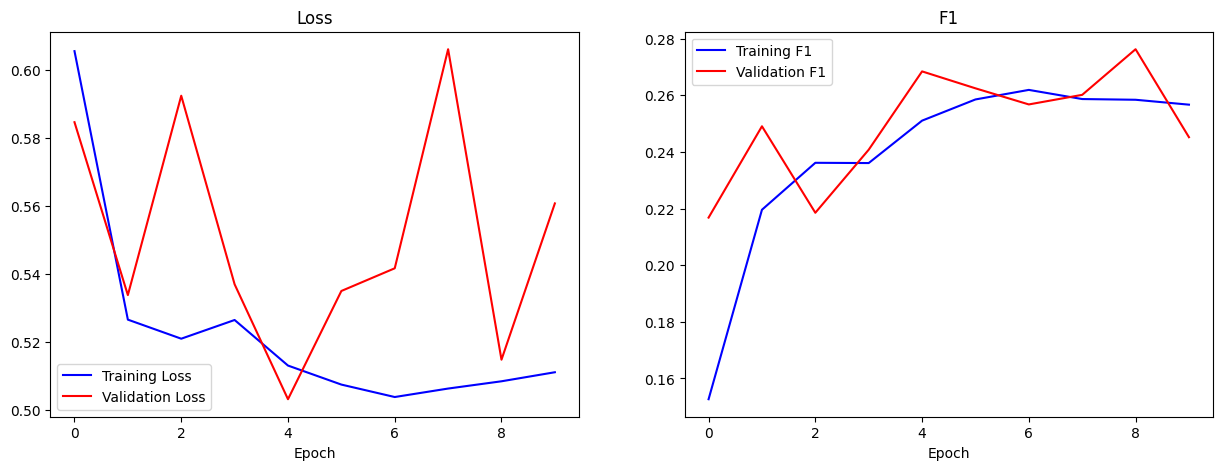

In [17]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [18]:
rnn_glove_model = rnn_glove_model.to('cpu')
torch.save(rnn_glove_model, "t1_model1_glove.pt")

In [19]:
test_accuracy, test_f1 = test("t1_model1_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.06080032169977182, 1: 0.039304610733182165, 2: 0.0824215900802334, 3: 0.0, 4: 0.0007145409074669524, 5: 0.007575757575757575, 6: 0.0, 7: 0.14844192634560907, 8: 0.031819688432217434, 9: 0.08955223880597014, 10: 0.07956318252730109, 11: 0.03708133971291866, 12: 0.05953002610966056, 13: 0.0, 14: 0.009722897423432185, 15: 0.08382348918009465, 16: 0.12594458438287154, 17: 0.06666666666666667, 18: 0.0, 19: 0.0, 20: 0.015463917525773196, 21: 0.0, 22: 0.0, 23: 0.17945945945945946, 24: 0.0, 25: 0.0, 26: 0.0}
Labelwise Accuracy Scores:
{0: 0.9470502549162418, 1: 0.21487603305785125, 2: 0.32848837209302323, 3: 0.0, 4: 0.0032258064516129032, 5: 0.043478260869565216, 6: 0.0, 7: 0.5900900900900901, 8: 0.12532637075718014, 9: 0.5581395348837209, 10: 0.4668192219679634, 11: 0.17415730337078653, 12: 0.17484662576687116, 13: 0.0, 14: 0.05649717514124294, 15: 0.8553880513679508, 16: 0.7882882882882883, 17: 0.1111111111111111, 18: 0.0, 19: 0.0, 20: 0.06593406593406594, 21: 0.0,

# For FastText Embeddings

In [20]:
rnn_fasttext_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_fasttext_model.parameters(), lr=0.001)

In [21]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        rnn_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4418, Accuracy: 0.8901, F1: 0.3254
Validation: Loss: 0.3254, Accuracy: 0.9102, F1: 0.4095
Epoch 2/10
Training: Loss: 0.3150, Accuracy: 0.9141, F1: 0.4477
Validation: Loss: 0.2998, Accuracy: 0.9171, F1: 0.4637
Epoch 3/10
Training: Loss: 0.2827, Accuracy: 0.9225, F1: 0.4972
Validation: Loss: 0.2938, Accuracy: 0.9215, F1: 0.4851
Epoch 4/10
Training: Loss: 0.2632, Accuracy: 0.9271, F1: 0.5280
Validation: Loss: 0.2766, Accuracy: 0.9265, F1: 0.5147
Epoch 5/10
Training: Loss: 0.2503, Accuracy: 0.9304, F1: 0.5488
Validation: Loss: 0.2729, Accuracy: 0.9281, F1: 0.5182
Epoch 6/10
Training: Loss: 0.2430, Accuracy: 0.9319, F1: 0.5610
Validation: Loss: 0.2787, Accuracy: 0.9257, F1: 0.5181
Epoch 7/10
Training: Loss: 0.2347, Accuracy: 0.9335, F1: 0.5742
Validation: Loss: 0.2897, Accuracy: 0.9250, F1: 0.5127
Epoch 8/10
Training: Loss: 0.2352, Accuracy: 0.9340, F1: 0.5815
Validation: Loss: 0.2803, Accuracy: 0.9261, F1: 0.5227
Epoch 9/10
Training: Loss: 0.2300, Accuracy: 0.9

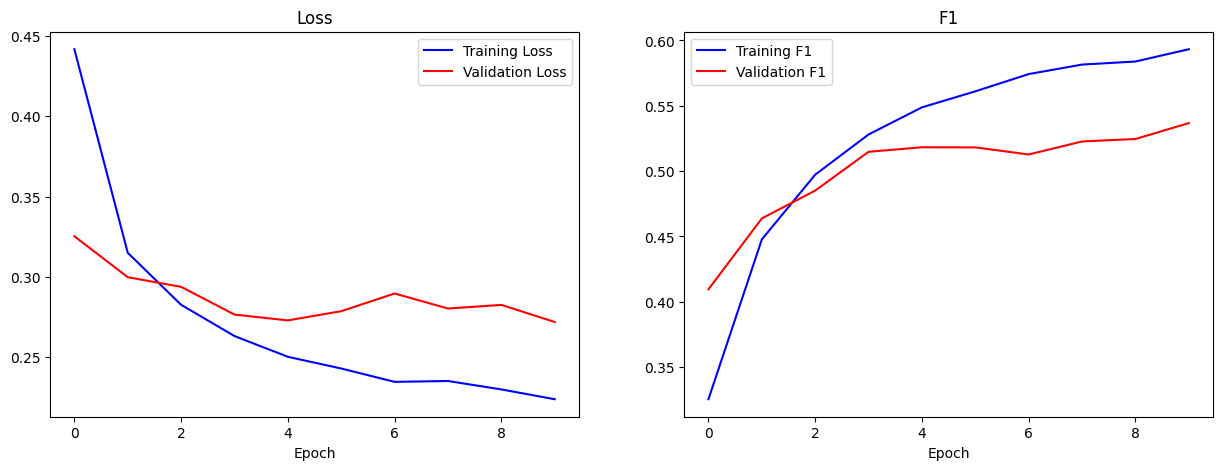

In [22]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [23]:
rnn_fasttext_model = rnn_fasttext_model.to('cpu')
torch.save(rnn_fasttext_model, "t1_model1_fasttext.pt")

In [24]:
test_accuracy, test_f1 = test("t1_model1_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.039673244607618174, 1: 0.048749999999999995, 2: 0.11195826645264847, 3: 0.0186219739292365, 4: 0.03029095257074532, 5: 0.051775147928994084, 6: 0.055645422193464904, 7: 0.06310160427807487, 8: 0.08233486943164363, 9: 0.2301255230125523, 10: 0.12564102564102564, 11: 0.14497354497354498, 12: 0.0905050505050505, 13: 0.03188405797101449, 14: 0.05551020408163265, 15: 0.06322529011604641, 16: 0.30744336569579284, 17: 0.15384615384615383, 18: 0.08571428571428572, 19: 0.05543710021321962, 20: 0.06106870229007634, 21: 0.0, 22: 0.0, 23: 0.2371134020618557, 24: 0.1, 25: 0.0, 26: 0.06557377049180328}
Labelwise Accuracy Scores:
{0: 0.9837946103423161, 1: 0.32231404958677684, 2: 0.811046511627907, 3: 0.12578616352201258, 4: 0.24516129032258063, 5: 0.5072463768115942, 6: 0.441025641025641, 7: 0.5315315315315315, 8: 0.6997389033942559, 9: 0.8527131782945736, 10: 0.7848970251716247, 11: 0.7696629213483146, 12: 0.6871165644171779, 13: 0.1896551724137931, 14: 0.384180790960452,